# Chapter 16: Play Atari Pong with Policy Gradients

Policy gradients are a policy-based reinforcement learning (RL) mechanism, as opposed to the value based RL that we talked about so far. But it’s a very powerful tool, and we’ll use it to play Atari games such as Breakout or Pong in this book. 

The idea behind policy gradients is different from Q learning: it directly tells the model how to adjust the weights to reach the optimum. If the prediction is smaller than the desired outcome, the model will adjust the weights so that the prediction will increase. Similarly, if the prediction is greater than the desired outcome, the model will adjust the weights so that the prediction will decrease. Further, the magnitude of the adjustment is directly proportional to the rewards: the greater the reward, the greater the adjustment. 

We’ll use the Atari Pong game as an example on how to do that in this chapter. The code I use in this chapter is largely based on Andrej's code below 
https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

At the end of this chapter, you'll create an animation to illustrate how deep Q learning works. Specifically, at each time step, you'll put the graph of the cart pole on the left. You'll draw on the right the current state of the game: cart position, cart velocity, pole angle, and pole velocity. You'll feed the information to the trained deep Q network to get the Q-values of moving the cart left and moving the cart right, respectively. The move with higher Q-value is then highlighted in red on the graph, and that's the action taken by the agent. You'll repeat this in each of the 200 time steps, like so:  
<img src="https://gattonweb.uky.edu/faculty/lium/ml/cartpole_DeepQs.gif" />

***
$\mathbf{\text{Create a subfolder for files in Chapter 16}}$<br>
***
We'll put all files in Chapter 16 in a subfolder /files/ch16. The code in the cell below will create the subfolder.

***

In [1]:
import os

os.makedirs("files/ch16", exist_ok=True)

## 1. Get Started with Atari Games

In this section, you'll start to play the Atari Pong game in the OpenAI Gym environment and understand its features.

First, we need to install Atari in the OpenAI Gym environment. Activate the virtual environment ***animatedML***, then enter the following command in the Anaconda prompt or a terminal (MAC or Linux):

`conda install -c conda-forge atari_py`

After that, you need to install ROMS on your computer. Go to the link below 

http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html

and download the file Roms.rar to your computer. Extract the two folders, ROMS and HC Roms, and place them in a folder on your computer. For example, I place them in C:\temp on my computer. 

After that, run the following command in the Anaconda prompt or a terminal (MAC or Linux) with the virtual environment ***animatedML*** activated:

`python -m atari_py.import_roms <path to folder>`

For example, since I saved the files in C:\temp on my computer, I ran:

`python -m atari_py.import_roms C:\temp` 

to install ROMS. 

### 1.1. The Pong Game



In [2]:
import gym
env = gym.make("Pong-v0")
env.reset()
env.render()

True

You should see a Pong game frame in a separate window. 

You can check the action space and observation space of the game as follows:

In [3]:
# Print out all possible actions in this game
actions = env.action_space
print(f"The action space in the Pong game is {actions}")

# Print out the observation space in this game
obs_space = env.observation_space
print(f"The observation space in the Pong game is {obs_space}")

The action space in the Pong game is Discrete(6)
The observation space in the Pong game is Box(210, 160, 3)


There are six possible actions the gaent can take. But for all practical purpose, we only need to decide whether the paddle should go up (action 2) or down (action 3). So we can treat this as a binary classification problem. 

Each observation is a color picture 210 pixels tall and 160 pixels wide. The following cell displays an observation.

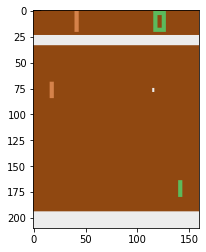

In [15]:
import matplotlib.pyplot as plt
import numpy as np

env.reset()
# run 200 steps so that the pong appears in the picture
for _ in range(200):
    action = np.random.choice([2,3])
    obs, reward, done, info = env.step(action)
plt.imshow(obs)
plt.show()

### 1.2. Process the Game Frames
The input size of the game frame is too large, we'll process the image to reduce the size while retaining vital information to train the model to win the game.

Specifically, we'll perform cropping, downsizing, and differencing before we feed the data into the model to train the agent. 

#### Cropping
We'll remove the top and the bottom of the game frame to reduce input size as follows.

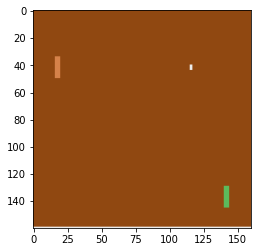

In [16]:
obs_cropped = obs[35:195]
plt.imshow(obs_cropped)
plt.show()

The size of the picture is now 160 by 160 by 3. We need to further reduce the size of the picture. 

#### Downsizing
We'll use every other row and every other column so that the input size is smaller. Further, we'll use just one of the three color channels to further reduce size, like so:

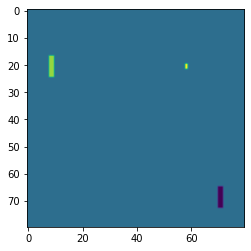

In [17]:
obs_downsized = obs_cropped[::2,::2,0]
plt.imshow(obs_downsized)
plt.show()

The size of the processed picture is now 80 by 80, a small fraction of the origional size. However, the picture doesn't tell us the movement of the Pong ball. We can potentially use two consecutive pictures, but a better idea is to use the difference between two consecutuve frames. 

#### Differencing
We'll get the difference of the two consetive frames after processing. The script below shows how. 

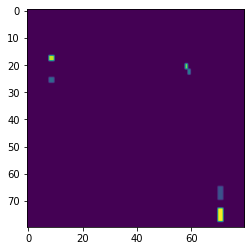

In [18]:
action = np.random.choice([2,3])
next_obs, reward, done, info = env.step(action)

next_obs_cropped = next_obs[35:195]
next_obs_downsized = next_obs_cropped[::2,::2,0]

dif = next_obs_downsized - obs_downsized
plt.imshow(dif)
plt.show()

Now we are ready to feed the data into a model to train the agent. 

## 2. Train the Agent Using Policy Gradients

We'll use policy gradients to train the agent. 

### 2.1. The Idea Behind Policy Gradients

Policy gradients train the model by adjusting the weights, similar to the idea of gradient descent we discussed in Chapters 2 and 3. However, instead of adjusting the parameters by $$ -1 \times Learning Rate \times gradient.$$ we we discussed in Chapter 2, we'll adjust the parameters by $$ -1 \times Learning Rate \times gradient\times reward$$

The idea is that if the action leads to high rewards, we ajdust the parameters more, so as to reach the optimal outcome. 





### 2.2. Different Versions of the Pong Game

For games in the OpenAI Gym environment, there are different versions:
* v0: there is a 25% chance that the previous action will be repeated instead of the issued action;
* v4: 0% probability of repeating the previous action; but skip 2-5 frames randomly;
* Deterministic-v4: 0% probability of repeating the previous action; skip a fixed 4 frames. 

When we train the game, we don't use the aciton with the highest probability. Instead, we randomly choose the action proportional to the predicted probability from the model. This is similar to the Exploration versus Exploitation in Q training.  

Further, the program is trained on the v0 version of the game. We'll discuss which version to test the trained model on later. 

### 2.3. The Script to Train the Model
The program is similar to the original code by Andrej Karpathy. I made some needed changes due to Python package updates, such as cPickle, r.size...

For more detailed explanations, read through Andrej's post here:  http://karpathy.github.io/2016/05/31/rl/ 

In [ ]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
  model = pickle.load(open('pg_pong.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
  model['W2'] = np.random.randn(H) / np.sqrt(H)
  
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, len(r))):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0

round = 0
while True:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if round>0 else np.zeros(D)
  prev_x = cur_x
  round += 1

  # forward the policy network and sample an action from the returned probability
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  # grad that encourages the action that was taken to be taken 
  dlogps.append(y - aprob) 
  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  drs.append(reward) 

  if done: # an episode finished
    episode_number += 1
    round=0
    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    grad = policy_backward(eph, epdlogp)
    for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    if running_reward is None:
        running_reward = reward_sum  
    else:
        running_reward = running_reward * 0.99 + reward_sum * 0.01
    print('episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
    if episode_number % 100 == 0: pickle.dump(model, open('pg_pong.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

It takes one to two days to train the model. 

## 3. Test the Trained Model
We'll first test one game using the trained model. We then test it on 100 games and see what's the average score. We finally discuss testing on different versions of the Pong game. 

### 3.1. Test One Game
The program below test the game for one episode. Each player can score between -21 to 21 points. 21 is the perfect score, and -21 is the worst possible score. 

In [3]:
import numpy as np
import pickle
import gym

D = 80 * 80 # input dimensionality: 80x80 grid
model = pickle.load(open('files/ch16/pg_pong.p', 'rb'))
def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) 

def prepro(I):
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

env = gym.make("PongDeterministic-v4")
observation = env.reset()
prev_x = None # used in computing the difference frame
reward_sum = 0

while True:
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  env.render()
  aprob, h = policy_forward(x)
  action = 2 if 0.5 < aprob else 3 
  observation, reward, done, info = env.step(action)
  reward_sum += reward
  if done: 
    print(f"score is {reward_sum}")
    break
env.close()

C:\Users\hlliu2\AppData\Local\Temp\ipykernel_13944\4234674740.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


score is 21.0


The trained agent had a perfect score of 21.

### 3.2. Test on Multiple Games
Next, we'll test on 20 games and see what is the average score. 

In [7]:
import numpy as np
import pickle
import gym

D = 80 * 80 # input dimensionality: 80x80 grid
#model = pickle.load(open('pg_pong.p', 'rb'))
model = pickle.load(open('files/ch16/pg_pong.p', 'rb'))
def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) 

def prepro(I):
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

env = gym.make("PongDeterministic-v4")


scores = []
for i in range(20):  
    observation = env.reset()
    prev_x = None # used in computing the difference frame
    reward_sum = 0
    while True:
      cur_x = prepro(observation)
      x = cur_x - prev_x if prev_x is not None else np.zeros(D)
      prev_x = cur_x
      #env.render()
      aprob, h = policy_forward(x)
      action = 2 if 0.5 < aprob else 3 
      observation, reward, done, info = env.step(action)
      reward_sum += reward
      if done: 
        scores.append(reward_sum)
        print(f"score is {reward_sum}")
        break
env.close()

print(f"the average score is {np.mean(scores)}")

C:\Users\hlliu2\AppData\Local\Temp\ipykernel_13944\58405484.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
score is 21.0
the average score is 21.0


The trained agent plays perfectly in every game.

### 3.3. Test on Pong-v0
We have tested the trained agent on PongDeterministic-v4. Next, we test what if we use Pong-v0.

In [6]:
import numpy as np
import pickle
import gym

D = 80 * 80 # input dimensionality: 80x80 grid
#model = pickle.load(open('pg_pong.p', 'rb'))
model = pickle.load(open('files/ch16/pg_pong.p', 'rb'))
def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) 

def prepro(I):
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

env = gym.make("Pong-v0")


scores = []
for i in range(20):  
    observation = env.reset()
    prev_x = None # used in computing the difference frame
    reward_sum = 0
    while True:
      cur_x = prepro(observation)
      x = cur_x - prev_x if prev_x is not None else np.zeros(D)
      prev_x = cur_x
      #env.render()
      aprob, h = policy_forward(x)
      action = 2 if 0.5 < aprob else 3 
      observation, reward, done, info = env.step(action)
      reward_sum += reward
      if done: 
        scores.append(reward_sum)
        print(f"score is {reward_sum}")
        break
env.close()

print(f"the average score is {np.mean(scores)}")

C:\Users\hlliu2\AppData\Local\Temp\ipykernel_13944\1371521744.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


score is -18.0
score is -19.0
score is -14.0
score is -18.0
score is -21.0
score is -19.0
score is -9.0
score is -13.0
score is -19.0
score is -15.0
score is -14.0
score is -10.0
score is -21.0
score is -15.0
score is -21.0
score is -13.0
score is -15.0
score is -12.0
score is -12.0
score is -14.0
the average score is -15.6


The agent performs poorly in this version of the game. This is due to that fact that the paddle repeats the previous move 25% of the time, instead of the move predicted by the trained model. 

## 4. Animate the Pong Game Before and After Training
Next, we'll animate how the agent performs before and after training. We'll put the two games side by side so that you can compare them.

### 4.1. Record A Full Game with the Trained Agent
We'll first record a full game using the trained model.

The script below accomplishes that.

In [8]:
import numpy as np
import pickle
import gym

D = 80 * 80 # input dimensionality: 80x80 grid
#model = pickle.load(open('pg_pong.p', 'rb'))
model = pickle.load(open('files\ch16\pg_pong.p', 'rb'))
def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) 

def prepro(I):
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

env = gym.make("PongDeterministic-v4")

frames = []

observation = env.reset()
prev_x = None # used in computing the difference frame
reward_sum = 0
while True:
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  #env.render()
  aprob, h = policy_forward(x)
  action = 2 if 0.5 < aprob else 3 
  observation, reward, done, info = env.step(action)
  reward_sum += reward
  frames.append(env.render(mode='rgb_array'))
  if done: 
    break
env.close()

import imageio
imageio.mimsave('files\ch16\pong_trained.gif', frames, fps=24)

C:\Users\hlliu2\AppData\Local\Temp\ipykernel_13944\3406337539.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


All the frames from the game are saved as numpy arrays in the list *frames*. We also converted the frames into an animation pong_trained.gif. If you open the file, you should see the following:

In [9]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/pong_trained.gif"/>

The trained agent is the player one the right with a green paddle. As you can see, the final score is 21 to 0. The trained agent won all 21 points, without letting the opponet score one single point. 

### 4.2. Record Games with Random Moves
Next, we'll record game frames when the agent makes random moves. We'll use them later for comparison purpose. 

In [10]:
env = gym.make("PongDeterministic-v4")

random_frames = []
 
observation = env.reset()
for _ in range(len(frames)):
  action = np.random.choice([2,3]) 
  observation, reward, done, info = env.step(action)
  random_frames.append(env.render(mode='rgb_array'))
env.close()

Note that by using the command
```python
for _ in range(len(frames))
```
we ensure that we get the same number of frames here as in the game with the trained agent. Therefore, later when we combine the frames, we don't have to worry about matching the number of frames. 

### 4.3. Combine the Animations
We'll combine the two games and form one single animation, with the game with untrained agents on the left, and the game with the trained agent on the right.

In [11]:
fs = []
for i in range(len(frames)):
    if i%2==0:
        f = frames[i]
        rf = random_frames[i]
        middle = np.full(f.shape, 255).astype("uint8")
        frf = np.concatenate([rf, middle, f], axis=1)
        fs.append(frf)
imageio.mimsave('files\ch16\pong_compare.gif', fs, fps=24) 

The animation looks as follows:

In [13]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/pong_compare.gif" />

Again, the agent has the green paddle. The left side shows what happens if the agent chooses random moves. The right side shows a full game when the agent is trained with policy gradients. The trained agent plays perfectly, earning a score of 21-0. 